In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df, load_big_df
from utils import two_sig_signal, two_sig_signal_multi, get_yulu_df, nice_hist_series, plot_box_plot
from utils import plot_box_plot_a, get_future_df, get_future_smoothed_df

from lin_regr_utils import lin_regr, linearity_test, residual_independence_test, homoscedasticity_test, residual_normality_test
from lin_regr_utils import multicollinearity_test, get_stats

# import warnings
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_future_df_yulu(df_raw, ref_df, interval='1S'):
    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')
    df_raw['round_time'] = df_raw['time'].dt.round(interval)
    
    rrdf = ref_df.rename(columns={'time': 'r_time'})

    df_raw_r = pd.merge(df_raw, rrdf, left_on='round_time', right_on='r_time', how='left') #.drop(columns=['r_time'])
    return df_raw_r

def process_yulu(df_raw, time_step='1T'):
    df_raw = df_raw[['time', 'mid', 'trade_side', 'trade_size', 'trade_price']]
    # display(df_raw)

    df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')

    # Group by 'time' and conditionally sum 'A' based on 'B' == 'X'
    df_buy = df_raw[df_raw['trade_side'] == 'Buy'].groupby('time', as_index=False).agg(
        trade_mul_sum=('mul', 'sum'),
        trade_size_sum=('trade_size', 'sum'),
    )
    df_sell = df_raw[df_raw['trade_side'] == 'Sell'].groupby('time', as_index=False).agg(
        trade_mul_sum=('mul', 'sum'),
        trade_size_sum=('trade_size', 'sum'),
    )

    df_buy.set_index('time', inplace=True)
    df_sell.set_index('time', inplace=True)

    df_ob = df_raw[df_raw['trade_side'].isna()].drop(columns=['trade_side', 'trade_size', 'trade_price'])
    df_ob.set_index('time', inplace=True)

    # time_step = '1T'
    # SUM_TRADE_SIZE = df_raw['trade_size'].sum()
    df_buy_resampled = df_buy.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_mul_sum': 'sum',  # Min for min price
        }).rename(columns={'trade_size_sum': 'buy_size', 'trade_mul_sum': 'buy_mul'})
    df_sell_resampled = df_sell.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_mul_sum': 'sum',  # Min for min price
        }).rename(columns={'trade_size_sum': 'sell_size', 'trade_mul_sum': 'sell_mul'})
    df_ob_resampled = df_ob.resample(time_step).last()
    df = df_ob_resampled.join(df_buy_resampled.join(df_sell_resampled, how='outer'), how='outer')

    for col in ['buy_size', 'sell_size']:
        df[col] = df[col].fillna(0)

    for col in ['mid']:
        df[col] = df[col].ffill()  
    return df

In [4]:
df_raw = pd.read_csv("../simulation_data/output_20250414_GALAUSDTOB500_GALAUSDTtrades_AA.csv")
# df_raw
df = df_raw

<ipython-input-3-8b40f1f7bdb6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
<ipython-input-3-8b40f1f7bdb6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 735184 entries, 0 to 735183
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         735184 non-null  datetime64[ns]
 1   bbid         630049 non-null  float64       
 2   bask         630049 non-null  float64       
 3   bsize        630049 non-null  float64       
 4   asize        630049 non-null  float64       
 5   trade_side   105135 non-null  object        
 6   trade_size   105135 non-null  float64       
 7   trade_price  105135 non-null  float64       
 8   round_time   735184 non-null  datetime64[ns]
 9   r_time       735184 non-null  datetime64[ns]
 10  mid          735184 non-null  float64       
 11  mul          0 non-null       float64       
 12  buy_size     735184 non-null  float64       
 13  buy_mul      734770 non-null  float64       
 14  sell_size    735184 non-null  float64       
 15  sell_mul     734969 non-null  floa

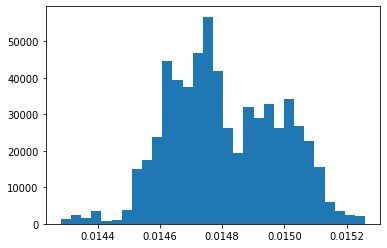

In [5]:
TIME_STEP = '10S'

ydf = df_raw[df_raw.columns]
ydf['mid'] = (ydf['bbid'] + ydf['bask']) / 2

df1 = process_yulu(ydf, TIME_STEP)
df1['vwap'] = (df1['buy_mul'] + df1['sell_mul']) / (df1['buy_size'] + df1['sell_size'])
df1['alpha'] = np.log(df1['vwap'].rolling(5).mean() / df1['vwap'].rolling(20).mean())
fdf1 = get_future_df_yulu(df_raw, df1.reset_index(), TIME_STEP)

plt.hist(fdf1['vwap'], bins=30)
fdf1.info()

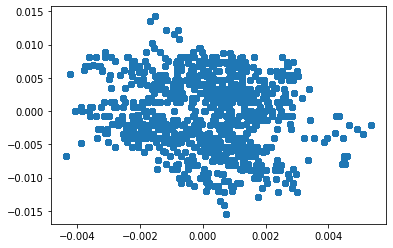

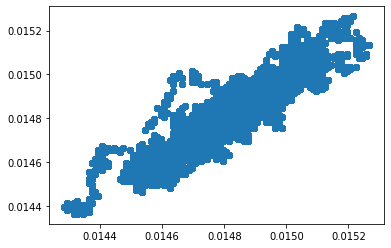

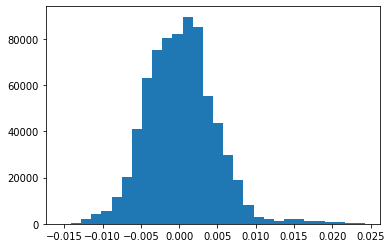

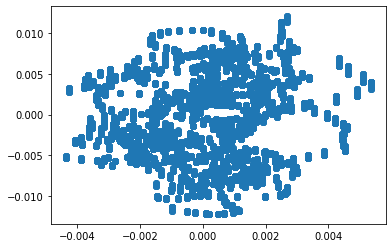

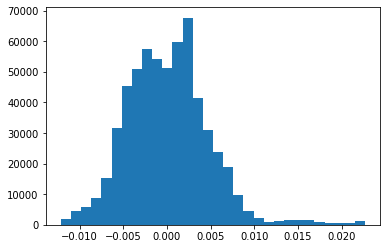

In [15]:
%reload_ext autoreload
# dff.iloc[300:400]
# bdf

fdf11 = get_future_df(fdf1.reset_index(), '10S')
plt.scatter(fdf11['alpha'], fdf11['future_1m_return'])
plt.show()

plt.scatter(fdf11['mid'], fdf11['future_1m_mid'])
plt.show()

plt.hist(fdf11['future_1m_return'], bins=30)
plt.show()
# plot_box_plot_a(fdf11, 'alpha', 'future_1m_return')

fdf11 = get_future_smoothed_df(fdf1.reset_index(), '1S', 600, 120, 120)
plt.scatter(fdf11['alpha'], fdf11['future_smoothed_600_return'])
plt.show()

plt.scatter(fdf11['mid'], fdf11['future_1m_mid'])
plt.show()

plt.hist(fdf11['future_smoothed_600_return'], bins=30)
plt.show()
# plot_box_plot_a(fdf11, 'alpha', 'future_smoothed_600_return')

# bdf = dff.dropna(subset=['buy_trade_size_sum'])
# fbdf = fdf.dropna(subset=['buy_trade_size_sum'])

# EDGE = 1

# tick_edge_bdf = fbdf[fbdf['buy_trade_price_max'] - fbdf['bask'] >= 0.00001 * EDGE]
# tick_edge_bdf['pnl'] = (tick_edge_bdf['bask'] + 0.00001 * EDGE - tick_edge_bdf['future_1m_mid']) * 100000
# tick_edge_bdf['mid_pnl'] = (tick_edge_bdf['future_1m_mid'] - tick_edge_bdf['mid']) * 100000
# plt.hist(tick_edge_bdf['pnl'], bins=30)
# print(f"{len(tick_edge_bdf)}, {tick_edge_bdf['pnl'].mean():.2f}, {tick_edge_bdf['pnl'].std():.2f}, {tick_edge_bdf['pnl'].sum():.2f}")
# fdf11.columns

